First of all, we have to import all the libraries

In [72]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
import math
plt.style.use('ggplot')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words[:10])

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antonindoat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The dataset is about reviews for a movie. It's composed of two columns : the review and the sentiment of the review, if it's a positive or a negative review.

In [73]:
df = pd.read_csv('IMDB_Dataset.csv')

In [74]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

We don't have any missing values.

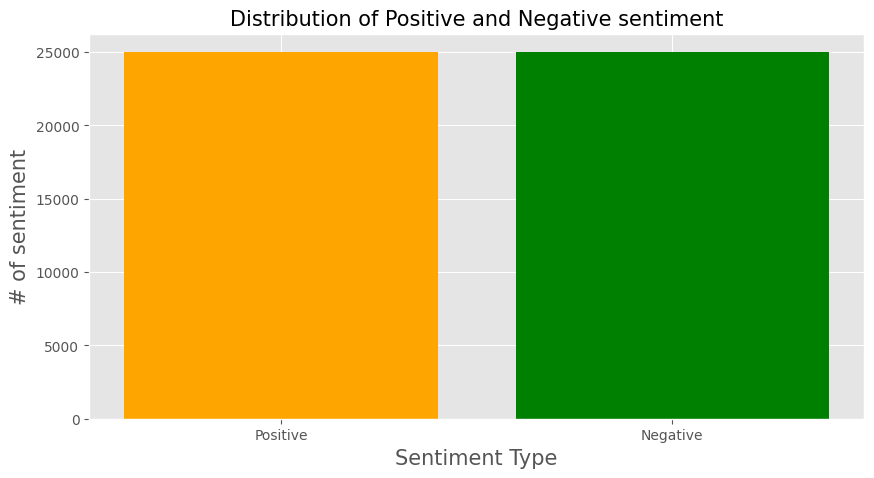

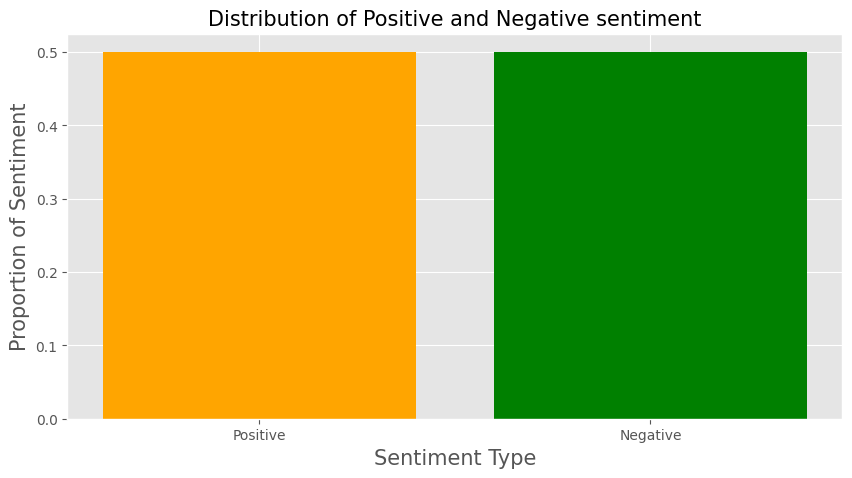

In [75]:
# Comptes
positive_count = sum(df["sentiment"] == "positive")
negative_count = sum(df["sentiment"] == "negative")
total_len = len(df["sentiment"])

# Plot nombre absolu
plt.figure(figsize=(10, 5))
plt.bar('Positive', positive_count, color='orange')
plt.bar('Negative', negative_count, color='green')
plt.title('Distribution of Positive and Negative sentiment', size=15)
plt.xlabel('Sentiment Type', size=15)
plt.ylabel('# of sentiment', size=15)
plt.show()

# Plot proportion
plt.figure(figsize=(10, 5))
plt.bar('Positive', positive_count / total_len, color='orange')
plt.bar('Negative', negative_count / total_len, color='green')
plt.title('Distribution of Positive and Negative sentiment', size=15)
plt.xlabel('Sentiment Type', size=15)
plt.ylabel('Proportion of Sentiment', size=15)
plt.show()

Defining the target of the model and the feature.

In [76]:
features = df['review']
targets = df['sentiment']

Cleaning the dataset by removing the stopwords and normalizing the features.

In [77]:
#List of stop words
stop_words = set(stopwords.words('english'))

#Delete stopwords
features.apply(
    lambda x: " ".join([word for word in x.split() if word not in stop_words])
)
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized


features_clean = normalize(features)


The parameter max_vocab is the number of words that covered 95% of the text.

In [78]:
from collections import Counter

all_words = ' '.join(features_clean).split()
word_counts = Counter(all_words)
total_words = sum(word_counts.values())

sorted_counts = sorted(word_counts.values(), reverse=True)
coverage = 0
for i, c in enumerate(sorted_counts):
    coverage += c
    if coverage / total_words > 0.95:
        print("95% of the text covered with", i+1, "words")
        break


95% of the text covered with 10494 words


Splitting the text in train and test

In [79]:
X_train, X_test, y_train, y_test = train_test_split(features_clean, targets, test_size=0.20, random_state=18)

Tokenization

In [80]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [81]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Padding of the text.

In [82]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

RNN model 

In [83]:
# Modèle
model = tf.keras.Sequential([
    # Embedding avec input_length
    tf.keras.layers.Embedding(max_vocab, output_dim=128, input_length=256),
    
    # LSTM bidirectionnels
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    
    # Dense + Dropout
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),#to avoid overfitting
    
    # Sortie binaire
    tf.keras.layers.Dense(1)
])

# Compiler le modèle
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Build explicite pour que summary affiche les paramètres
model.build(input_shape=(None, 256))
model.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 256, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 256, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 32)             │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,399,553 (5.34 MB)

 Trainable params: 1,399,553 (5.34 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
# Convertir en binaire
y_train = np.array([1 if label == 'positive' else 0 for label in y_train], dtype=np.float32)
y_test  = np.array([1 if label == 'positive' else 0 for label in y_test], dtype=np.float32)


Training the LSTM RNN 

In [85]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=32, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 336s 293ms/step - accuracy: 0.7296 - loss: 0.4983 - val_accuracy: 0.8700 - val_loss: 0.3357
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 338s 300ms/step - accuracy: 0.8959 - loss: 0.2761 - val_accuracy: 0.8867 - val_loss: 0.2850
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 351s 312ms/step - accuracy: 0.9210 - loss: 0.2199 - val_accuracy: 0.8832 - val_loss: 0.2932
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 342s 304ms/step - accuracy: 0.9364 - loss: 0.1839 - val_accuracy: 0.8800 - val_loss: 0.3145


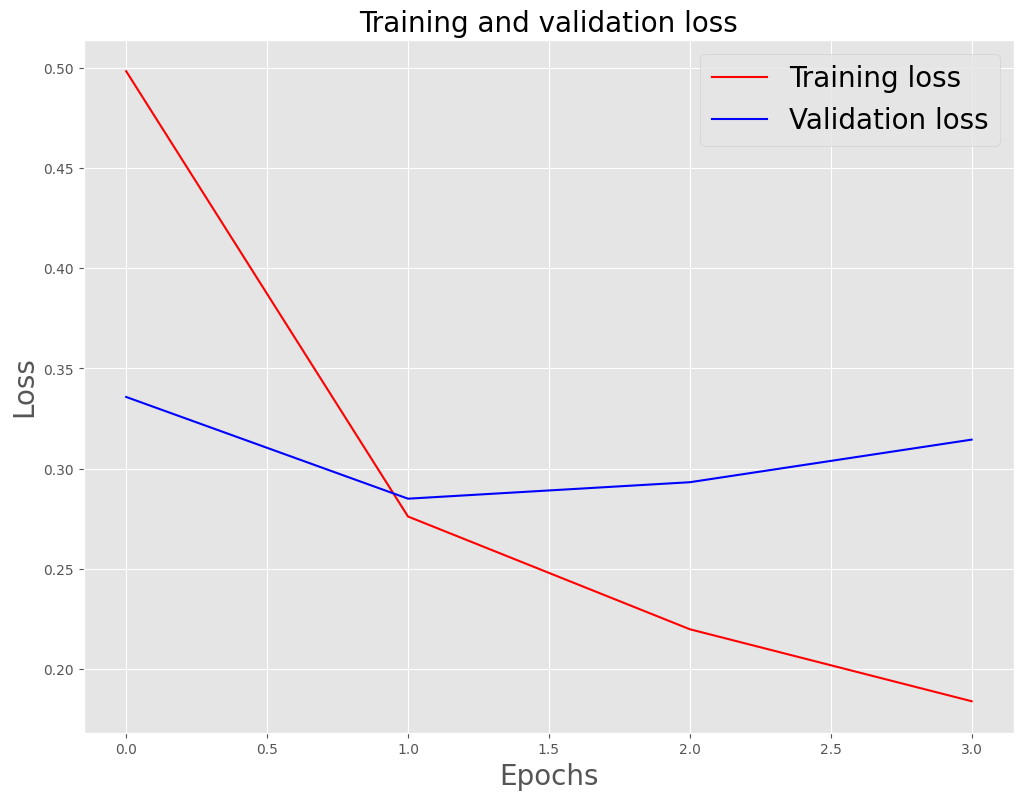

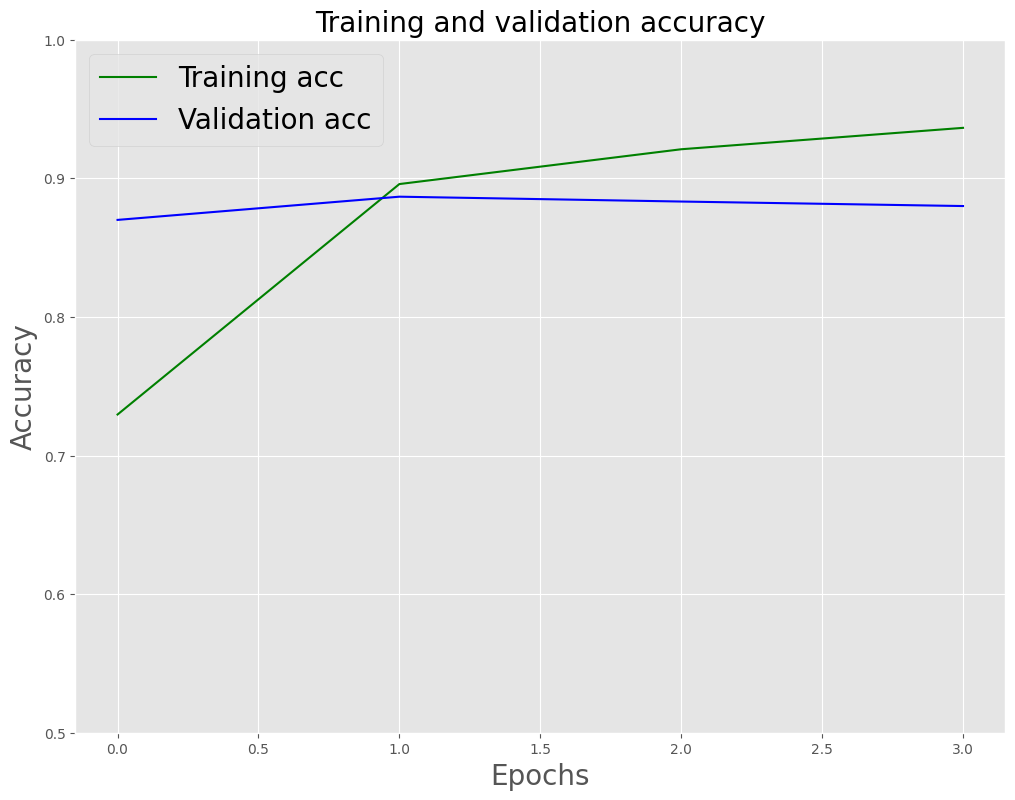

In [86]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

The plots show that the model is learning: training loss decreases and training accuracy increases while validation metrics remain relatively stable, indicating good generalization.


In [88]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.8874 - loss: 0.2757


[0.2757112681865692, 0.8873999714851379]

In [89]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step


In [90]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.8874
Precision on testing set: 0.8855872245805538
Recall on testing set: 0.8866626189030561


The model shows good performance on unseen data

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

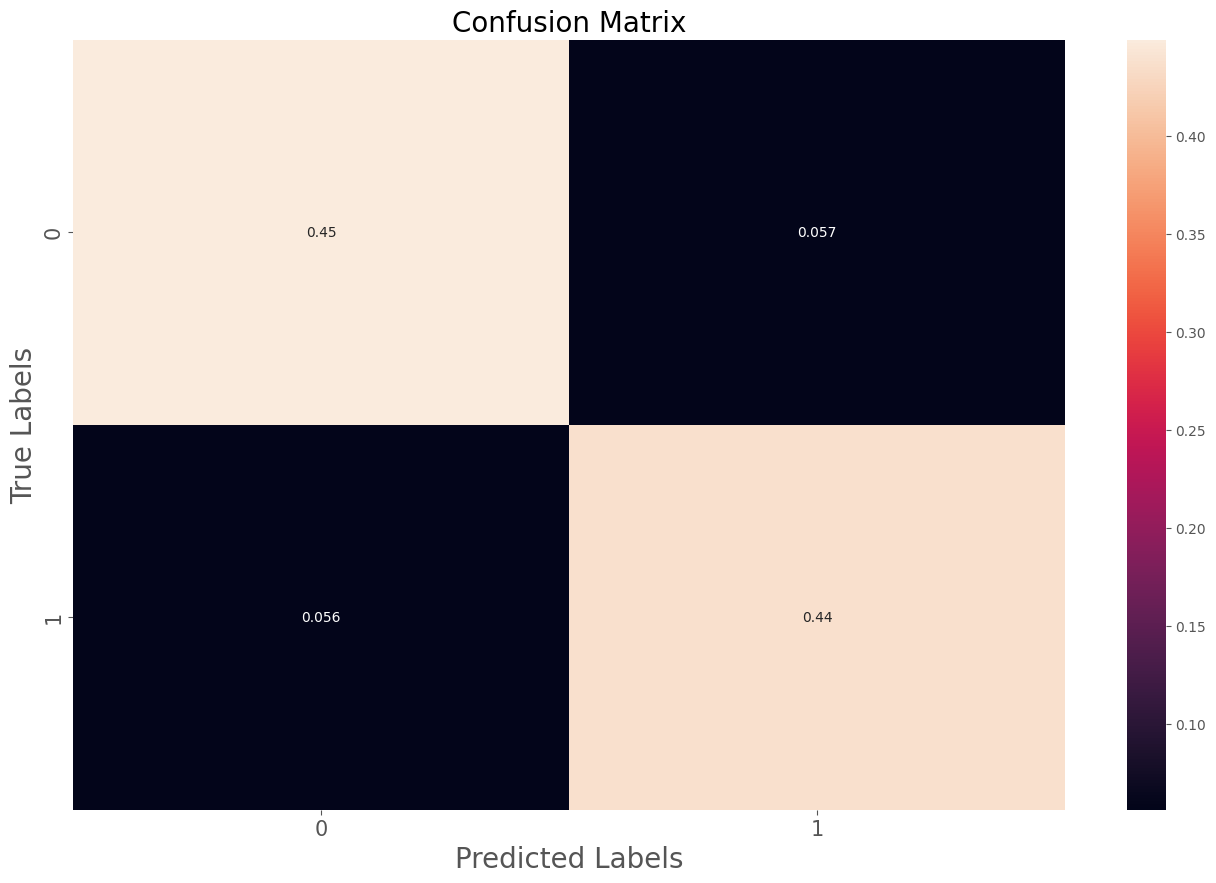

In [91]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

To conclude, the bidirectional LSTM model achieved strong performance on movie review classification, with accuracy, precision, and recall around 0.887 on the test set. Dropout regularization (0.6) helped reduce overfitting while maintaining high accuracy. Overall, the model generalizes well and provides a solid baseline for sentiment analysis.